### CHANGE VERSION OF TENSORFLOW

In [ ]:
!pip install tensorflow==2.9.1
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ACCESS THE DRIVE

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/AN2DL/homework1

/gdrive/My Drive/AN2DL/homework1


### IMPORT LIBRARIES

In [4]:
import tensorflow as tf
import cython as c
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import scipy 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import skimage as si
import imutils as im
import tqdm as tq
import psutil as ps
import h5py as h5
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### SET THE SEED

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### UNZIP THE DATASET

In [ ]:
!unzip dataset_homework1.zip

Archive:  dataset_homework1.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_final/Species1/00016.jpg  
  infla

### SPLIT IN TRAIN, VAL AND TEST SETS

In [ ]:
!pip install split-folders
import splitfolders
training_ratio=0.85    
validation_ratio=0.15 
splitfolders.ratio('training_data_final', output="dataset_folders", seed=seed, ratio=(training_ratio, validation_ratio)) 
!find ./output/ -type d -print -exec sh -c "ls {} | wc -l | head -n1" \;

# Or, with oversampling:

# !pip install split-folders
# import splitfolders
# splitfolders.fixed('training_data_final', output="dataset_folders", seed=seed, oversample=True, fixed=80) 
# !find ./dataset_folders/ -type d -print -exec sh -c "ls {} | wc -l | head -n1" \;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:29, 120.97 files/s]


./output/
2
./output/train
8
./output/train/Species1
158
./output/train/Species2
452
./output/train/Species3
437
./output/train/Species4
434
./output/train/Species5
451
./output/train/Species6
188
./output/train/Species7
456
./output/train/Species8
431
./output/val
8
./output/val/Species1
28
./output/val/Species2
80
./output/val/Species3
78
./output/val/Species4
77
./output/val/Species5
80
./output/val/Species6
34
./output/val/Species7
81
./output/val/Species8
77


### SET FOLDERS

In [7]:
# Dataset folders 
dataset_dir = 'dataset_folders'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

### LABELS

In [8]:
labels = ['Species1',       
          'Species2',           
          'Species3',    
          'Species4',              
          'Species5',          
          'Species6',          
          'Species7',   
          'Species8']   

number_of_classes = 8

### MODEL HYPERPARAMETERES AND VARIABLES

In [9]:
image_width, resized_width = 96, 224
image_height, resized_height = 96, 224
channels = 3

input_size = (image_height, image_width)
resized_size  = (resized_height, resized_width)

input_shape = (image_height, image_width, channels)
resized_input_shape = (resized_height, resized_width, channels)

epochs = 200 #number of epochs
patience_epochs = 20 # number of epochs for early stopping
batch_size = 256 # number of samples managed per step

initial_learning_rate = 0.1 # variable learning rate

### EXAMPLE OF IMAGES FROM THE DATASET

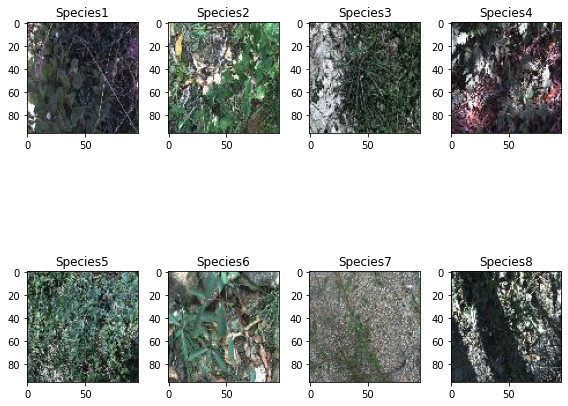

In [10]:
# Plot example images from dataset

num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(4*num_row,2*num_col))
for i in range(num_row*num_col):
  if i < 9:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA LOADER AND DATA AUGMENTATION

In [11]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the ImageDataGenerator to read them from disk.
# Needed if the images are too many to be kept in memory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import the preprocessing function needed for the transfer leaning network used below, must use the same preprocessing for the images 
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input 

#Image data generators can be used for data augmentation
# Create an instance of ImageDataGenerator for training, validation, and test sets. Transformations are applied only on training images
train_data_gen = ImageDataGenerator(rotation_range=90,         #rotate +/- x degree
                                        height_shift_range=0.1,  # [low, high] pixel shift
                                        width_shift_range=0.1,   # [low, high] pixel shift
                                        zoom_range=0.4,         #zoom rate
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        brightness_range=[0.4,1.6], #ranges of brightness modification
                                        shear_range=0.2, 
                                        fill_mode='reflect',  #fill pixel outised the image due to shifts and rotations with black pixels
                                        preprocessing_function=preprocess_input)    #apply the neural network's preprocessing function
                                        
                                        
#flow from directory takes images from the directory passed, divides them into batched of the specified size and applies the image generator to obtain a
#random configuration of the orginal image, the transformations applied depend on the parameter passed to the ImageDataGenerator
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                            target_size=resized_size,#size of images
                                            interpolation="bicubic",
                                            color_mode='rgb',#channels
                                            classes=labels, # set to labels of classes, see above
                                            class_mode='categorical',
                                            batch_size=batch_size, 
                                            shuffle=True,#data gets shuffled when epoch ends and new one begins
                                            seed=seed)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                    
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                            target_size=resized_size,
                                            interpolation="bicubic",
                                            color_mode='rgb',
                                            classes=labels, 
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=False,#shuffle irrelevant for validation (and testing)
                                            )

Found 3007 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


### CLASS WEIGHTING FOR GENERATORS

In [12]:
# Used for re-weighting classes considering that the number of samples in the dataset for each class are unbalanced

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_gen.classes),
    y = train_gen.classes
)
train_class_weights = dict(enumerate(class_weights))
train_class_weights = {cls: weight.item() for cls, weight in train_class_weights.items()}
print(train_class_weights)

{0: 2.3789556962025316, 1: 0.8315818584070797, 2: 0.8601258581235698, 3: 0.8660714285714286, 4: 0.8334257206208425, 5: 1.9993351063829787, 6: 0.8242872807017544, 7: 0.8720997679814385}


### FUNCTION TO CREATE FOLDERS AND CALLBACKS

In [13]:
### Utility function to create folders and callbacks for training
from datetime import datetime

callbacks = []

best_val_acc = 0.0

class MyCallback(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')

    def on_epoch_end(self, epoch, logs=None):
        global best_val_acc
        if logs['val_accuracy'] > best_val_acc:
            best_val_acc = round(logs['val_accuracy'], 4)
        print("\nBEST CURRENT ACCURACY VALIDATION:    " + str(best_val_acc))

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')  # create a folder for experiences
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%m%d_%H-%M-%S')  # assign different name every time experiment is run

  exp_dir = os.path.join(exps_dir, str(now) + '_' + model_name)
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  #CHECKPOINT CALLBACK
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), #where to save model/checkpoints
                                                     save_weights_only=False, # True to save only weights, false save all the model
                                                     save_best_only=True,# True to save only the best epoch, false save all epochs
                                                     monitor='val_accuracy',#monitor the accuracy metric
                                                     mode='max')
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
 # By default shows losses and metrics for both training and validation in tensorboard
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  #epoch frequency, if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)#append to callback list

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', verbose=True, mode='max', patience=patience_epochs, restore_best_weights=True)
  callbacks.append(es_callback)

  # Print best validation accuracy
  #-------------------------------
  print_acc = MyCallback()
  callbacks.append(print_acc)

  return callbacks

### TRANSFER LEARNING MODEL

52606240/52606240 [==============================] - 2s 0us/step
Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2

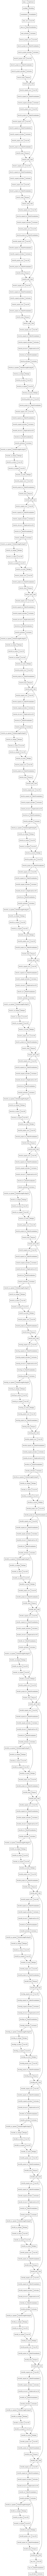

In [14]:
# Download and plot the EfficientNetV2B3 model
pre_trained_model = tfk.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=resized_input_shape
)

#set EfficientNetV2B3 as non-trainable (transfer learning)
pre_trained_model.trainable = False

#show and plot the structure of the EfficientNetV2B3 network  
pre_trained_model.summary()
tfk.utils.plot_model(pre_trained_model)

In [15]:
# Use the supernet as feature extractor
input_layer = tfk.Input(shape=resized_input_shape)

supernet = pre_trained_model(input_layer) #2048 output

#concatenate a fully connected NN to the exit of the pre-trained model
glob_pooling = tfkl.GlobalAveragePooling2D()(supernet)
batch_norm = tfkl.BatchNormalization()(glob_pooling)

classifier1 = tfkl.Dense(512,kernel_initializer = tfk.initializers.GlorotUniform(seed))(batch_norm)
classifier1 = tfkl.ELU()(classifier1)#use ELU activation function
classifier1 = tfkl.Dropout(0.3, seed=seed)(classifier1)#close to the input layer, use lower dropout rate

classifier2 = tfkl.Dense(256,kernel_initializer = tfk.initializers.GlorotUniform(seed))(classifier1)
classifier2 = tfkl.ELU()(classifier2)
classifier2 = tfkl.Dropout(0.6, seed=seed)(classifier2)#in the middle of the hidden layers, increase droput rate

classifier3 = tfkl.Dense(64,kernel_initializer = tfk.initializers.GlorotUniform(seed))(classifier2)
classifier3 = tfkl.ELU()(classifier3)

output_layer = tfkl.Dense(number_of_classes, activation='softmax',kernel_initializer = tfk.initializers.GlorotUniform(seed))(classifier3)

# Connect input and output through the Model class
transfer_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

# Compile the model
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=100000, # 100 000 initially
decay_rate=0.96,
staircase=True)

transfer_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), metrics='accuracy')
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, 7, 7, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                             

### FINE TUNING

In [16]:
#set pre-trained model as trainable
transfer_model.get_layer('efficientnetv2-b3').trainable=True

#freeze up to 170th level
to_freeze=170
for layer in transfer_model.get_layer('efficientnetv2-b3').layers[:to_freeze]:
      layer.trainable = False

#freeze batch_normalization layers
for layer in transfer_model.get_layer('efficientnetv2-b3').layers:
   if isinstance(layer, tfk.layers.BatchNormalization):
      layer.trainable = False

#check1
print("check trainability whole model")
for i, layer in enumerate(transfer_model.layers):
    print(i, layer.name, layer.trainable)

#check2
print("\ncheck trainability of efficientnet model")
for i, layer in enumerate(transfer_model.get_layer('efficientnetv2-b3').layers):
    print(i, layer.name, layer.trainable)


# Compile the model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate,
decay_steps=100000, # 100 000 initially
decay_rate=0.96,
staircase=True)

transfer_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), metrics='accuracy')

check trainability whole model
0 input_2 True
1 efficientnetv2-b3 True
2 global_average_pooling2d True
3 batch_normalization True
4 dense True
5 elu True
6 dropout True
7 dense_1 True
8 elu_1 True
9 dropout_1 True
10 dense_2 True
11 elu_2 True
12 dense_3 True

check trainability of efficientnet model
0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expan

### TRAIN THE MODEL

In [17]:
# Initialization of num_model to save models
num_model = 27

In [18]:
# Description saved in checkpoints and saved model
description = "Efficientnet_v2_b3_batch_layers_TOT-170_trainable"

In [ ]:
# Train the model
transfer_history = transfer_model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,    
    callbacks = create_folders_and_callbacks(f"model{num_model}_{description}"),
    class_weight = train_class_weights # Use it if no oversampling was performed
).history

### SAVE THE MODEL

In [ ]:
# Save best epoch model
best_train = round(max(history['accuracy']), 4)
best_validation = round(max(history['val_accuracy']), 4)
transfer_model.save(f"experiments/Model{num_model}_{description}")

# Save history
hist_df = pd.DataFrame(history) #with pandas
hist_json_file = f"experiments/Model{num_model}_{description}/history.json" 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# # or save to csv: 
# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

f = open(f"experiments/Model{num_model}_{description}/metadata.txt","w+")

metadata_dict = {"input_shape" : input_shape, "resized_shape" : resized_shape, "epochs" : epochs, "batch_size" : batch_size, "patience_epochs" : patience_epochs, "learning_rata_init" : lr_init}

f.write("{\n")
for k in metadata_dict.keys():
    f.write(F"{k} = {metadata_dict[k]}\n")
f.write("}\n\n")

f.write("Best training accuracy: " + str(best_train) + " = " + str(best_train) + "%\n")
f.write("Best validation accuracy: " + str(best_validation) + " = " + str(best_validation) + "%\n")
    
f.close()

### PLOT

In [ ]:
# Best metrics for accuracy:
best_train = round(max(history['accuracy']), 4)
best_validation = round(max(history['val_accuracy']), 4)
print("Best training accuracy: ")
print(str(best_train) + " = " + str(best_train) + "%\n")
print("Best validation accuracy: ")
print(str(best_validation) + " = " + str(best_validation) + "%\n\n")

# Plot the training
plt.figure(figsize=(15,5))
plt.plot(transfer_history['loss'][1:], label='training', alpha=.8, color='#ff7f0e')
plt.plot(transfer_history['val_loss'][1:], label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(transfer_history['accuracy'][1:], label='training', alpha=.8, color='#ff7f0e')
plt.plot(transfer_history['val_accuracy'][1:], label='validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### TENSORBOARD

In [ ]:
%load_ext tensorboard
%tensorboard --logdir data_augmentation_experiments